### 研究不同日期对于小费的影响

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

In [6]:
data = pd.read_csv("./data/tips.csv")
tips = data["tip"].values

days = data["day"].unique()
dim = len(days)  # NOTE待估计参数维数
day_labels = np.arange(dim)

data["day_idx"] = data["day"].apply(lambda x: list(days).index(x))
# day_idxs = data["day_idx"].values
day_idxs = pd.Categorical(data["day"], categories=list(days)).codes

In [7]:
data

,total_bill,tip,sex,smoker,day,time,size,day_idx
0,16.99,1.01,Female,No,Sun,Dinner,2,0
1,10.34,1.66,Male,No,Sun,Dinner,3,0
2,21.01,3.50,Male,No,Sun,Dinner,3,0
3,23.68,3.31,Male,No,Sun,Dinner,2,0
4,24.59,3.61,Female,No,Sun,Dinner,4,0
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,1
240,27.18,2.00,Female,Yes,Sat,Dinner,2,1
241,22.67,2.00,Male,Yes,Sat,Dinner,2,1
242,17.82,1.75,Male,No,Sat,Dinner,2,1


**<font color=red> 注意**: 下面的mu[day_idxs]和sigma[day_idxs]的写法对应于两个tensor, shape=(N, 1), 然后pm.Normal会逐各对元素获得对应的y采样, shape=(N, 1)  
这种用法对PyMC中涉及混合效应等的编程非常重要 </font>

In [8]:
with pm.Model() as group_compar:
    mu = pm.Normal("mu", mu=0, sigma=10, shape=dim)
    sigma = pm.HalfNormal("sigma", sigma=10, shape=dim)
    y = pm.Normal("y", mu=mu[day_idxs], sigma=sigma[day_idxs], observed=tips)
    
    step = pm.Metropolis()
    trace = pm.sample(5000, chains=3, step=step)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [mu]
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


打印模型结构

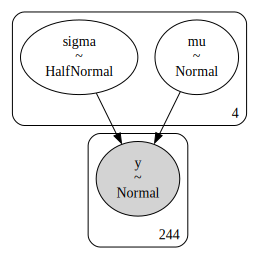

In [9]:
pm.model_graph.model_to_graphviz(group_compar)

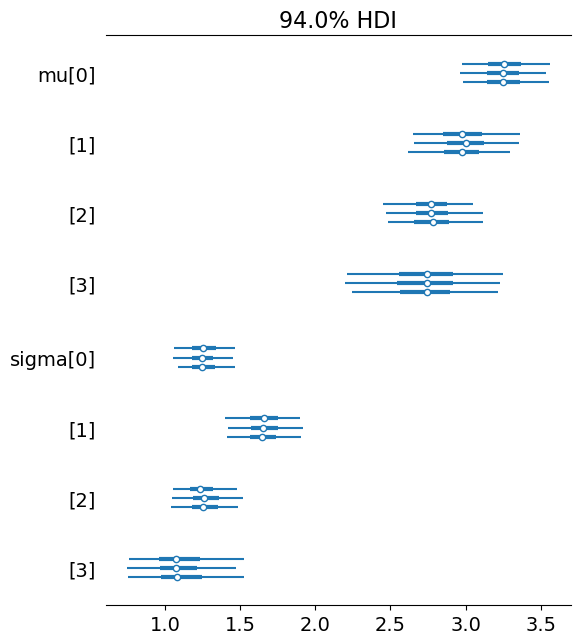

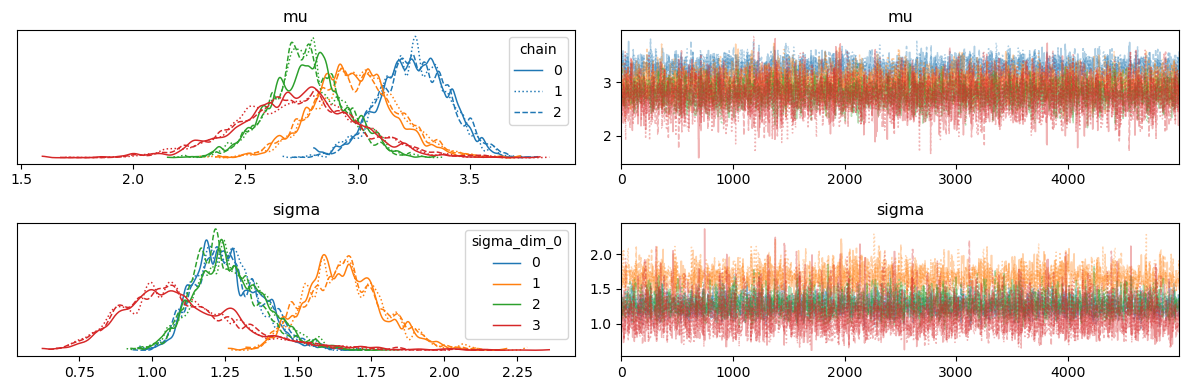

In [10]:
# trace = az.convert_to_dataset(trace)  # NOTE: 转换一遍

# 总结后验
with group_compar:
    az.plot_forest(trace)
    az.plot_trace(trace, compact=True, legend=True)  # TODO: 高维推理时该命令太耗时!!!
    plt.tight_layout()

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],3.253,0.156,2.948,3.533,0.004,0.003,1663.0,2083.0,1.00
mu[1],2.988,0.188,2.620,3.331,0.004,0.003,2765.0,2685.0,1.01
mu[2],2.775,0.167,2.473,3.102,0.003,0.002,2610.0,2514.0,1.00
mu[3],2.734,0.272,2.214,3.237,0.005,0.003,3114.0,3096.0,1.00
sigma[0],1.258,0.112,1.057,1.459,0.003,0.002,1856.0,1904.0,1.00
sigma[1],1.661,0.136,1.425,1.927,0.003,0.002,1811.0,2064.0,1.00
sigma[2],1.265,0.123,1.047,1.498,0.003,0.002,2186.0,2355.0,1.00
sigma[3],1.108,0.212,0.726,1.484,0.005,0.003,2276.0,2200.0,1.00
